In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
npzfile = np.load("toy_data_two_moon.npz")

x_train = torch.FloatTensor(npzfile['arr_0'])
y_train = torch.FloatTensor(npzfile['arr_2'])
x_test = torch.FloatTensor(npzfile['arr_1'])
y_test = torch.FloatTensor(npzfile['arr_3'])

Text(0.5, 1.0, 'Test data')

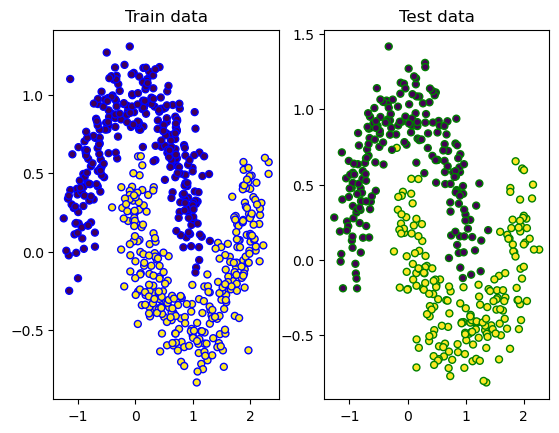

In [6]:
plt.subplot(121)
plt.scatter(x_train[:, 0], x_train[:, 1], marker='o', c=y_train[:,0], s=25, edgecolor='b')
plt.title("Train data")
plt.subplot(122)
plt.scatter(x_test[:, 0], x_test[:, 1], marker='o', c=y_test[:,0], s=25, edgecolor='g')
plt.title("Test data")

In [59]:
# 1. Define our linear model - 2 inputs, 1 output (bias is included in Linear layer)
linear = nn.Linear(2, 1) 
# 2. Define our loss function - MSE
loss_function = nn.MSELoss()
# 3. Create our optimizer - lr = 0.1
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

In [60]:
max_epoch = 100
loss_log = []
acc = []

for epoch in range(max_epoch):

    with torch.no_grad():
        y_test_hat = linear(x_test)
        class_pred = (y_test_hat >= 0).float() # (600, 1)
        acc.append(float(sum(class_pred == y_test))/ float(y_test.shape[0]))
    loss_log.append(loss.item)
    
    # Perform a training step
    y_train_hat = linear(x_train)
    loss = loss_function(y_train_hat, y_train) # (600, 1) & (600, 1)

    # Resets optimizer gradients
    optimizer.zero_grad()
    # Loss is a tensor calculated by the loss function, defined above
    loss.backward()
    optimizer.step()

    
print("Accuracy of linear model(GD): %.2f%% " %(acc[-1]*100))

Accuracy of linear model(GD): 63.75% 


Text(0, 0.5, 'Accuracy')

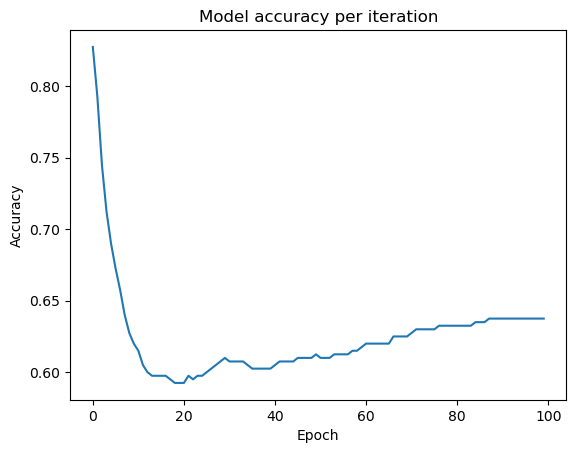

In [61]:
plt.plot(acc)
plt.title("Model accuracy per iteration")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

<h1>Logistic Regression </h1>
Why does a MLP lead to regression? We can see that with binary classification our goal is position the decision boundary such that it seperates the two classes. However by simply using linear regression with binary labels, we are forcing our model to try and position the decision boundary at a fixed distance from each data point, EVEN if it's on the "correct" side of the boundary. For example if a data point (label 1) was on the correct side of the boundary (positive side).

BUT it was a large distance away from the boundary, the model would be penalised and the boundary would be moved. This is an obvious problem if there is a large spread of values for a given class and can lead to our model to never converge to an optimal solution. <br>


Instead we think about moving the decision boundary *as far as possible* from the positive points on one side and *as far as possible* from the negative points on the other side. To do this we can utilize the sigmoid function, which maps all real numbers to the range 0 to 1: $$ R \to [0, 1] $$ <br>
By putting the sigmoid function on the output of our model we can see that to reach the target value 1, the raw model output would have to be $+\infty$ and 0 would be $-\infty$. The optimal solution would therefore achieve our goal of maximizing the distance between the data points and the decision boundary.<br>
While this solves one problem, it introduces another, the sigmoid function's gradient (derivative) is very flat for values witha large magnitude. If we were to use the MSE loss to train a model with a Sigmoid on the output, training would not only be slow, but may not progress at all! To see why, consider the case where our model as made a very large incorrect prediction, the gradient in this case would be very very small, the update to our model would therefore also be very small. <br>
To convince yourself of this try adding the sigmoid function (torch.sigmoid()) to the output of the above model and train!

<h3>Cross-Entropy loss</h3>
We therefore introduce a new loss function the <a href="https://en.wikipedia.org/wiki/Cross-entropy#Cross-entropy_loss_function_and_logistic_regression">Cross-Entropy loss</a>:

\begin{align}
L(\hat y, y) &= -y\ln (\hat y) - (1 - y)\ln (1 - \hat y)\\
\\
Where&\\
y &= Target \: value\\
\hat y &= Predicted \: value\\
\end{align}

We obtain this loss from the maximum log-likelihood of a multinomial (or binomial in the binary case) distribution. That is, instead of simply regressing to a value, we our model is now produces a probability distribution for the likelihood that a given input belongs to a given class. For the single output binary logistic case we get a single probability that the input belongs the the possitive (1) class. <br>
NOTE that using a Softmax output (rather than Sigmoid) with a Cross-Entropy loss is very common for multiclass classification but can also be used for binary classification (more on this later).

<h3>It's still a linear model!</h3>
It's important to realise that even though our model now has the non-linear Sigmoid function on it's output, this model is still only linear, an therefore can only produce a linear decision boundary! We've simply changed that way we think about our model and how we train it!

### Create a logistic regression model

In [63]:
# 1. Define our linear model - 2 inputs, 1 output (bias is included in linear layer)
logistic_linear = nn.Linear(2, 1) 

# 2. Define our loss function - Binary cross entropy with logits
# By using the "with logits" version PyTorch will assume the outputs given are the RAW model outputs -> logits - it is the inverse of the sigmoid function!)
loss_function = nn.BCEWithLogitsLoss()

# 3. Create our optimizer - lr = 0.1
logistic_optimizer = torch.optim.SGD(logistic_linear.parameters(), lr=0.1)

In [64]:
# Number of times we iterate over the dataset
max_epoch = 100

logistic_loss_log = [] # keep track of the loss values

logistic_acc = [] # keep track of the accuracy 

for epoch in range(max_epoch):
    # Use this when you want to calculate accuaries (for optimization purposes)
    with torch.no_grad():
        y_test_hat = logistic_linear(x_test)
        
        # The decision boundary is at 0.5 (between 0 and 1) AFTER the sigmoid
        # The input to the sigmoid function that gives 0.5 is 0!
        # Therefore the decision boundary for the RAW output is at 0!
        
        class_pred = (y_test_hat > 0).float()
        
        logistic_acc.append(float(sum(class_pred == y_test))/ float(y_test.shape[0]))
        
    # Perform a training step
    y_train_hat = logistic_linear(x_train)
    loss = loss_function(y_train_hat, y_train)
    
    logistic_optimizer.zero_grad()
    loss.backward()
    logistic_optimizer.step()

    logistic_loss_log.append(loss.item())
    
print("Accuracy of linear model(GD): %.2f%% " %(logistic_acc[-1]*100))

Accuracy of linear model(GD): 85.75% 


Text(0.5, 0, 'Accuracy')

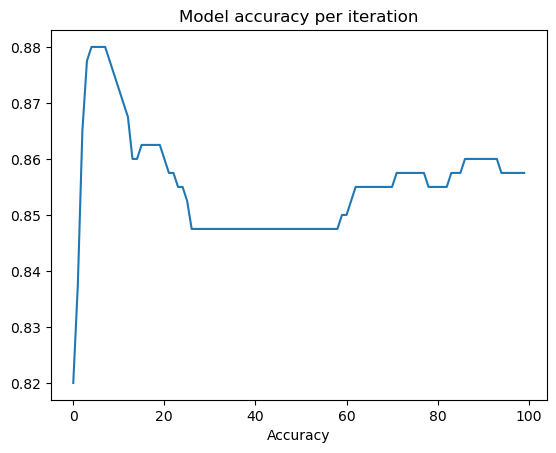

In [65]:
plt.plot(logistic_acc)
plt.title("Model accuracy per iteration")
plt.xlabel("Epoch")
plt.xlabel("Accuracy")

Text(0.5, 0, 'BCE Loss')

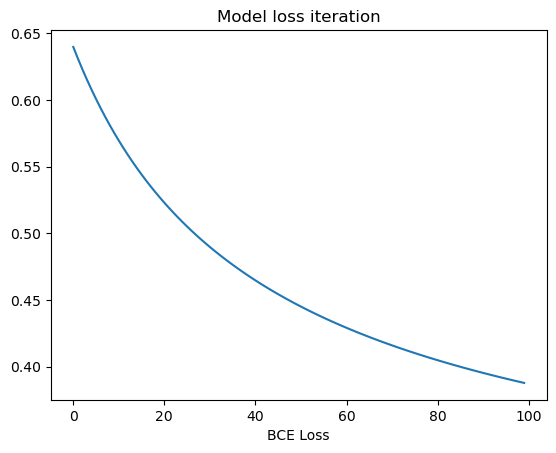

In [66]:
plt.plot(logistic_loss_log)
plt.title("Model loss iteration")
plt.xlabel("Epoch")
plt.xlabel("BCE Loss")